In [39]:
import numpy as np
import os
import matplotlib.pyplot as plt
from hhdc.canopy_plots import create_chm

cubes = []
for subfolder in os.listdir("cubes/SERC"):
    subfolder_path = os.path.join("cubes/SERC", subfolder)
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            if file.endswith('.npz'):
                cubes.append(os.path.join(subfolder_path, file))

print(f"Found {len(cubes)} cubes.")

Found 36121 cubes.


# 16 Random CHMs

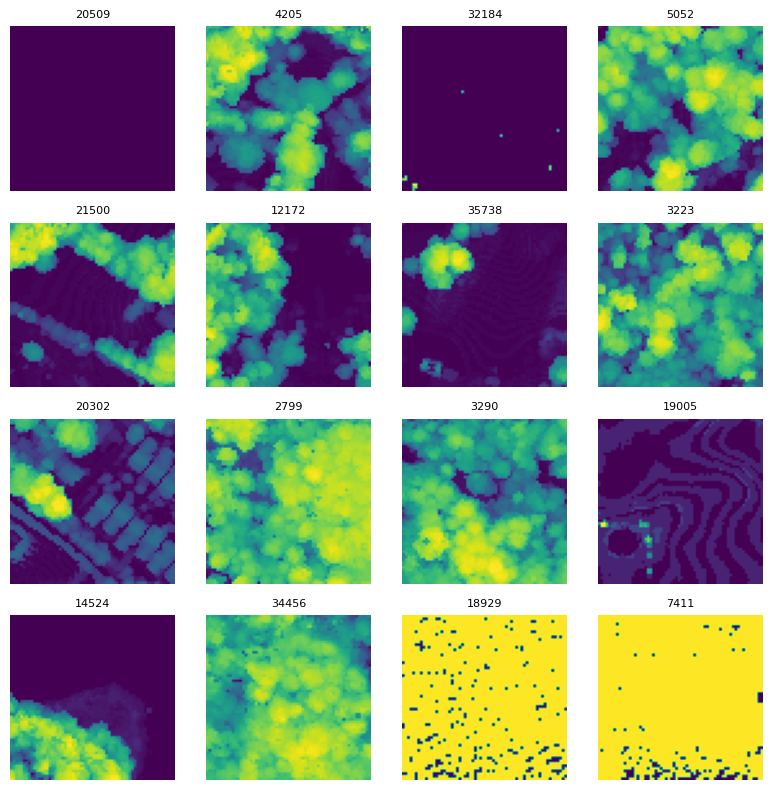

In [40]:
import random

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()

random_indices = random.sample(range(len(cubes)), 16)

for idx, ax in enumerate(axes):
    cube_path = cubes[random_indices[idx]]
    cube_data = np.load(cube_path)['cube']
    chm = create_chm(np.swapaxes(cube_data, 0, -1))[0]
    
    ax.imshow(chm)
    ax.set_title(f"{random_indices[idx]}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


# 16 Random DTMs with Hillshade

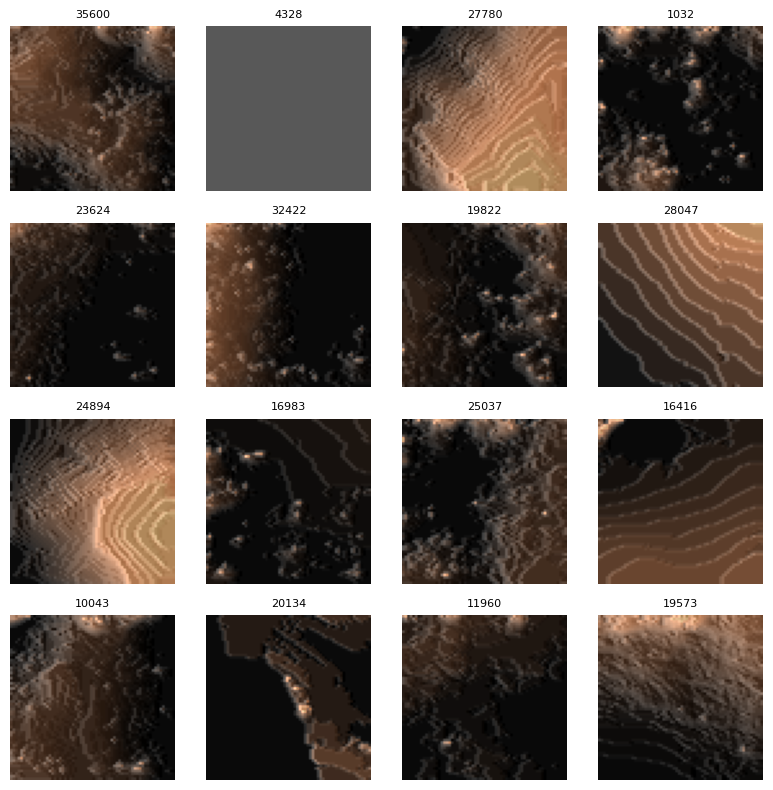

In [46]:
import random

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()

random_indices = random.sample(range(len(cubes)), 16)

for idx, ax in enumerate(axes):
    cube_path = cubes[random_indices[idx]]
    cube_data = np.load(cube_path)['cube']
    _, dtm, hillshade,_ = create_chm(np.swapaxes(cube_data, 0, -1))
    
    ax.imshow(dtm, cmap='copper')
    ax.imshow(hillshade, cmap='Grays', alpha=0.35)
    ax.set_title(f"{random_indices[idx]}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()